In [4]:
import urllib.request
import os
import tarfile

url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filepath='data/cifar-10-python.tar.gz'
if not os.path.isfile(filepath):
    result=urllib.request.urlretrieve(url,filepath)
    print('downloaded:',result)
else:
    print('Data file already exists.')
    
if not os.path.exists("data/cifar-10-batches-py"):
    tfile=tarfile.open("data/cifar-10-python.tar.gz",'r:gz')
    result=tfile.extractall('data/')
    print('Extracted to ./data/cifar-10-batches-py/')
else:
    print('Directory already exists.')

Data file already exists.
Directory already exists.


In [5]:
import numpy as np
import pickle as p

def load_CIFAR_batch(filename):
    with open(filename,'rb') as f:
        data_dict=p.load(f,encoding='bytes')
        images=data_dict[b'data']
        labels=data_dict[b'labels']
        
        images=images.reshape(10000,3,32,32)
        images=images.transpose(0,2,3,1)
        
        labels=np.array(labels)
        
        return images,labels
    
def load_CIFAR_data(data_dir):
    images_train=[]
    labels_train=[]
    for i in range(5):
        f=os.path.join(data_dir,'data_batch_%d'%(i+1))
        print('loading',f)
        image_batch,label_batch=load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain=np.concatenate(images_train)
        Ytrain=np.concatenate(labels_train)
        del image_batch,label_batch
    
    Xtest,Ytest=load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    return Xtrain,Ytrain,Xtest,Ytest

data_dir='data/cifar-10-batches-py/'
Xtrain,Ytrain,Xtest,Ytest=load_CIFAR_data(data_dir)

loading data/cifar-10-batches-py/data_batch_1
loading data/cifar-10-batches-py/data_batch_2
loading data/cifar-10-batches-py/data_batch_3
loading data/cifar-10-batches-py/data_batch_4
loading data/cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


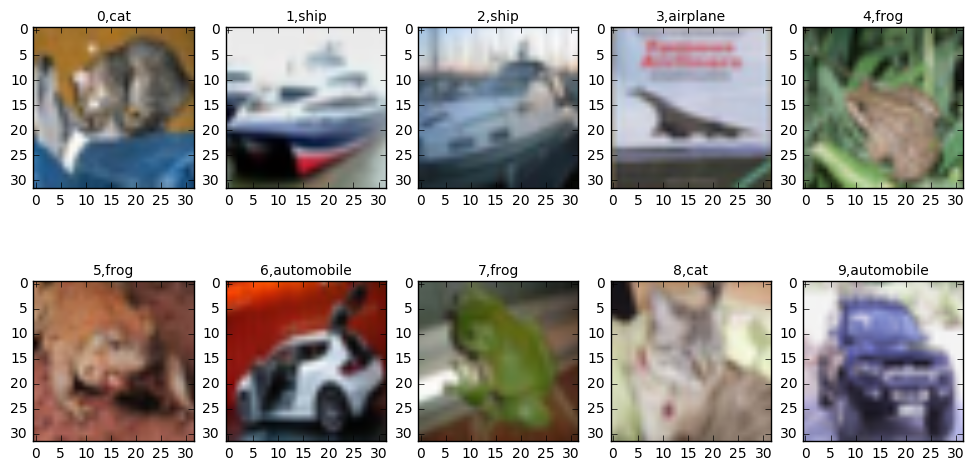

In [6]:
import matplotlib.pyplot as plt

label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig=plt.gcf()
    fig.set_size_inches(12,6)
    if num>10:
        num=10
    for i in range(0,num):
        ax=plt.subplot(2,5,1+i)
        ax.imshow(images[idx],cmap='binary')
        
        title=str(i)+','+label_dict[labels[idx]]
        if len(prediction)>0:
            title+='=>'+label_dict[prediction[idx]]
            
        ax.set_title(title,fontsize=10)
        
        idx+=1
    plt.show()
    
plot_images_labels_prediction(Xtest,Ytest,[],0,10)

In [7]:
Xtrain_normalize=Xtrain.astype('float32')/255.0
Xtest_normalize=Xtest.astype('float32')/255.0

In [8]:
from sklearn.preprocessing import OneHotEncoder

encoder=OneHotEncoder(sparse=False)

yy=[[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
Ytrain_reshape=Ytrain.reshape(-1,1)
Ytrain_onehot=encoder.transform(Ytrain_reshape)
Ytest_reshape=Ytest.reshape(-1,1)
Ytest_onehot=encoder.transform(Ytest_reshape)

In [9]:
import tensorflow as tf
tf.reset_default_graph()

In [10]:
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1),name='W')

def bias(shape):
    return tf.Variable(tf.constant(0.1,shape=shape),name='b')

#卷积操作
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

#池化操作
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [11]:
#输入层
with tf.name_scope('input_layer'):
    x=tf.placeholder('float',shape=[None,32,32,3],name='x')

#第一个卷积层
with tf.name_scope('conv_1'):
    W1=weight([3,3,3,32])
    b1=bias([32])
    conv_1=conv2d(x,W1)+b1
    conv_1=tf.nn.relu(conv_1)

#第一个池化层
with tf.name_scope('pool_1'):
    pool_1=max_pool_2x2(conv_1)
    
#第二个卷积层
with tf.name_scope('conv_2'):
    W2=weight([3,3,32,64])
    b2=bias([64])
    conv_2=conv2d(pool_1,W2)+b2
    conv_2=tf.nn.relu(conv_2)
    
#第二个池化层
with tf.name_scope('pool_2'):
    pool_2=max_pool_2x2(conv_2)
    
#全连接层
with tf.name_scope('fc'):
    W3=weight([4096,128])
    b3=bias([128])
    flat=tf.reshape(pool_2,[-1,4096])
    h=tf.nn.relu(tf.matmul(flat,W3)+b3)
    h_dropout=tf.nn.dropout(h,keep_prob=0.8)
    
#输出层
with tf.name_scope('output_layer'):
    W4=weight([128,10])
    b4=bias([10])
    pred=tf.nn.softmax(tf.matmul(h_dropout,W4)+b4)

In [12]:
with tf.name_scope("optimizer"):
    y=tf.placeholder("float",shape=[None,10],name="label")
    loss_funtion=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_funtion)

In [13]:
with tf.name_scope("evaluation"):
    correct_prediction=tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
    accuracy=tf.reduce_mean(tf.cast(correct_prediction,"float"))

In [14]:
from time import time

train_epochs=25
batch_size=50
total_batch=int(len(Xtrain)/batch_size)
epoch_list=[];accuracy_list=[];loss_list=[];

epoch=tf.Variable(0,name='epoch',trainable=False)

startTime=time()

sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)

断点续训，要先运行上面所有的代码

In [15]:
ckpt_dir="CIFAR10_log/"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
saver=tf.train.Saver(max_to_keep=1)

ckpt=tf.train.latest_checkpoint(ckpt_dir)
if ckpt!=None:
    saver.restore(sess,ckpt)
else:
    print("Training from scratch.")
    
start=sess.run(epoch)
print("Training starts from {} epoch.".format(start+1))

INFO:tensorflow:Restoring parameters from CIFAR10_log/CIFAR10_cnn_model.ckpt-3
Training starts from 3 epoch.


In [16]:
def get_train_batch(number,batch_size):
    return Xtrain_normalize[number*batch_size:(number+1)*batch_size],Ytrain_onehot[number*batch_size:(number+1)*batch_size]

for ep in range(start,train_epochs):
     
    for i in range(total_batch):
        batch_x,batch_y=get_train_batch(i,batch_size)
        sess.run(optimizer,feed_dict={x:batch_x,y:batch_y})
        if i%100==0:
            print("Step{}".format(i),"finished")
            
    loss,acc=sess.run([loss_funtion,accuracy],feed_dict={x:batch_x,y:batch_y})
    epoch_list.append(ep+1)
    loss_list.append(loss);
    accuracy_list.append(acc)
    
    print("Train epoch:",'%02d'%(sess.run(epoch)+1),"Loss=","{:.6f}".format(loss),"Accuracy=",acc)
    
    saver.save(sess,ckpt_dir+"CIFAR10_cnn_model.ckpt",global_step=ep+1)
    sess.run(epoch.assign(ep+1))
    
duration=time()-startTime
print("Train finished takes:",duration)

Step0 finished
Step100 finished
Step200 finished
Step300 finished
Step400 finished
Step500 finished
Step600 finished
Step700 finished
Step800 finished
Step900 finished
Train epoch: 03 Loss= 2.101644 Accuracy= 0.34
Step0 finished
Step100 finished
Step200 finished
Step300 finished
Step400 finished
Step500 finished
Step600 finished
Step700 finished
Step800 finished
Step900 finished
Train epoch: 04 Loss= 2.128885 Accuracy= 0.3
Step0 finished
Step100 finished
Step200 finished
Step300 finished
Step400 finished
Step500 finished
Step600 finished
Step700 finished
Step800 finished
Step900 finished
Train epoch: 05 Loss= 2.084146 Accuracy= 0.38
Step0 finished
Step100 finished
Step200 finished
Step300 finished
Step400 finished
Step500 finished
Step600 finished
Step700 finished
Step800 finished
Step900 finished
Train epoch: 06 Loss= 2.075264 Accuracy= 0.38
Step0 finished
Step100 finished
Step200 finished
Step300 finished
Step400 finished
Step500 finished
Step600 finished
Step700 finished
Step800 fin

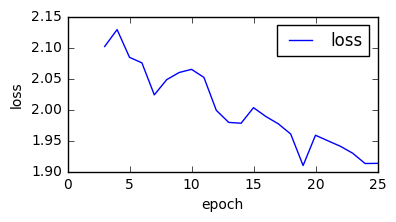

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig=plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list,loss_list,label="loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'],loc='upper right')

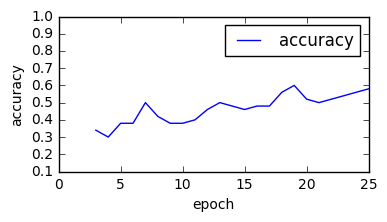

In [19]:
plt.plot(epoch_list,accuracy_list,label="accuracy")
fig=plt.gcf()
fig.set_size_inches(4,2)
plt.ylim(0.1,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [20]:
test_total_batch=int(len(Xtest_normalize)/batch_size)
test_acc_sum=0.0
for i in range(test_total_batch):
    test_image_batch=Xtest_normalize[i*batch_size:(i+1)*batch_size]
    test_label_batch=Ytest_onehot[i*batch_size:(i+1)*batch_size]
    test_batch_acc=sess.run(accuracy,feed_dict={x:test_image_batch,y:test_label_batch})
    test_acc_sum+=test_batch_acc
test_acc=float(test_acc_sum/test_total_batch)
print("Test accuracy:{:.6f}".format(test_acc))

Test accuracy:0.615900


In [21]:
test_pred=sess.run(pred,feed_dict={x:Xtest_normalize[:10]})
prediction_result=sess.run(tf.argmax(test_pred,1))

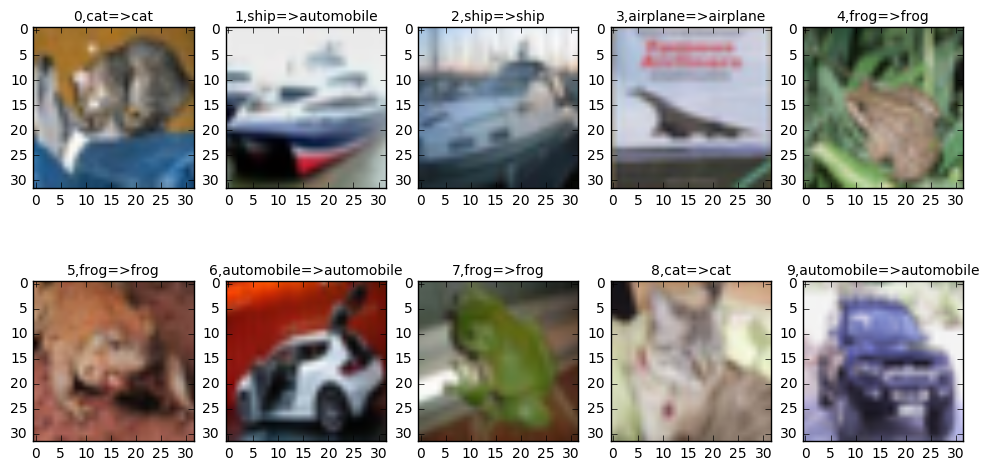

In [22]:
plot_images_labels_prediction(Xtest,Ytest,prediction_result,0,10)